In [9]:
import re
import pandas as pd
import requests
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import folium
from bs4 import BeautifulSoup
from geonamescache import GeonamesCache
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

In [10]:
url1 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log"
url2 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log2"
url3 = "https://raw.githubusercontent.com/robert456456456456/Web_server_log_parser/master/devops.log"
urls=[url1,url2,url3]

In [11]:
url =  "https://raw.githubusercontent.com/robert456456456456/Web_server_log_parser/master/devops.log"

In [15]:
logs = []
for j,url in enumerate(urls):
    content = requests.get(url)
    data = (content.content.decode('UTF-8'))
    if j==2:
        data = data.split("\r\n")
    else:
        data = data.split("\n")
    data.pop()
    logs.append(data)

In [16]:
final_log = [item for sublist in logs for item in sublist]

In [17]:
def filter(l):
    ip = l.split(" - - [",1)[0]
    l = l.split(" - - [",1)[1]
    time = l.split(" ",1)[0]
    l = l.split(" ",1)[1]
    offset = l.split("] ",1)[0]
    l = l.split('] "',1)[1]
    try:
        action = l.split(' HTTP/1.')[0]
        l = l.split(' HTTP/1.')[1]
        l = l.split('" ')[1]
    except:
        action = l.split('" ')[0]
        l = l.split('" ')[1]
    retcode = l.split(" ",1)[0]
    size = l.split(" ",1)[1]
    return [ip,time,offset,action,retcode,size]

In [18]:
cleaned_data = []
for j in data:
    cleaned_data.append(filter(j))

In [19]:
def extract_ips_website(data):
    ips = []
    website = []
    regexp="(.*?)- -"
    re2='(GET|POST|OPTIONS|HEAD)(.*?)(HTTP)'
    re3='(GET|POST|OPTIONS|HEAD)(.*?)(")'
    re4='(")(.*?)(")'
    for j,i in enumerate(data):
        ips.append(re.findall(regexp,i))
        try:
            website.append(re.findall(re2,i)[0][1])
        except:
            try:
                website.append(re.findall(re3,i)[0][1])
            except:
                w = (re.findall(re4,i)[0][1])
                if w == "-":
                    website.append("none")
    return ips,website

def extract_time(data):
    time = []
    regexp='\[(.*?)\]'
    for j,i in enumerate(data):
        time.append(re.findall(regexp,i)[0])
    return time
def get_location(ip):
    response = requests.get("https://geolocation-db.com/json/{}&position=true".format(ip)).json()
    return response['country_name']

In [20]:
e_ip,e_web = extract_ips_website(final_log)
times = extract_time(final_log)
e_ip = [i[0].strip() for i in e_ip]

## Getting geo location

In [21]:
def get_location(ip):
    response = requests.get("https://geolocation-db.com/json/{}&position=true".format(ip)).json()
    return response['country_name']

In [22]:
country = []
present = []
generated = []
for i in tqdm(e_ip):
    if i not in present:
        present.append(i)
        location = get_location(i)
        generated.append([i,location])
        country.append(location)
    else:
        for k in generated:
            if k[0]==i:
                country.append(location)

In [23]:
c = country.copy()

In [24]:
for i,j in enumerate(c):
    if j == "Not found":
        c[i] = "Unknown"

In [25]:
df = pd.DataFrame(data=e_ip,columns=["ip"])
df['website'] = e_web
df['time'] = times
df['Country'] = c
df.head(7)

,ip,website,time,Country
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,Unknown
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,Unknown
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,Unknown
3,212.92.37.62,/,15/Jan/2021:09:02:14 +0000,Spain
4,212.92.37.62,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Spain
5,212.92.37.62,/noindex/common/css/styles.css,15/Jan/2021:09:02:15 +0000,Spain
6,212.92.37.62,/noindex/common/images/pb-centos.png,15/Jan/2021:09:02:15 +0000,Spain


# Top 5 visited users

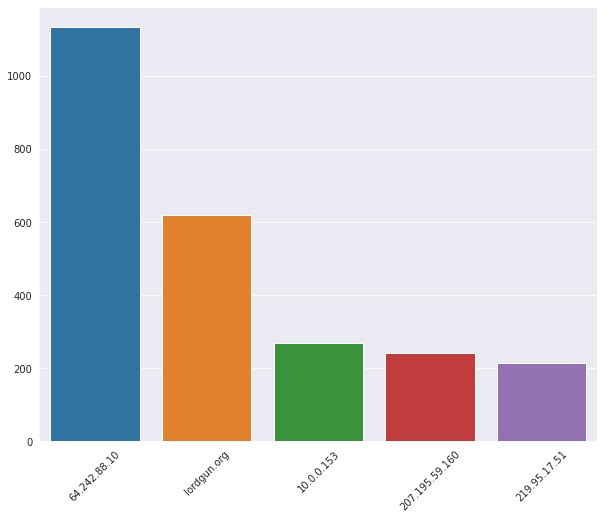

In [26]:
plt.figure(figsize=(10,8))
sns.barplot(x = df.ip.value_counts().index[:5], y = df.ip.value_counts().values[:5])
plt.xticks(rotation=45)
plt.show()

# Top 5 visited pages

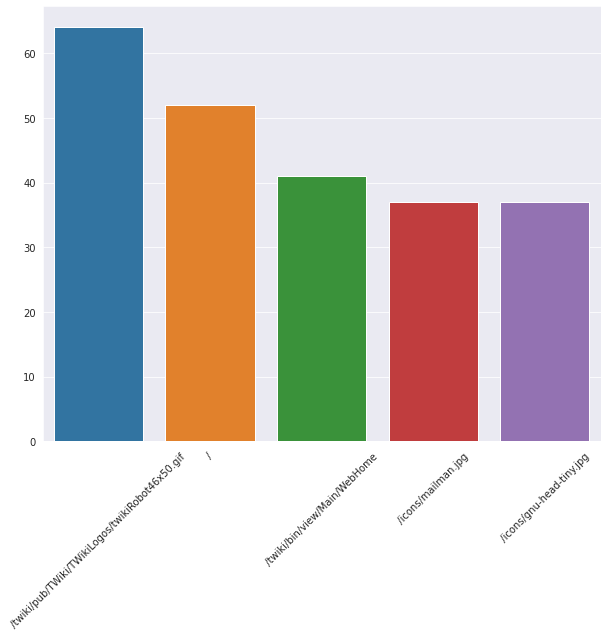

In [28]:
plt.figure(figsize=(10,8))
sns.barplot(x = df.website.value_counts().index[:5], y = df.website.value_counts().values[:5])
plt.xticks(rotation=45)
plt.show()

# Least 5 visited pages

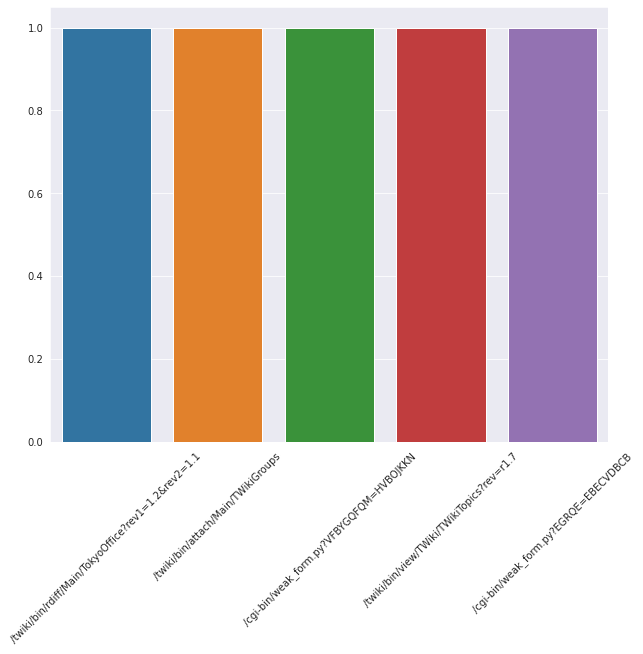

In [29]:
plt.figure(figsize=(10,8))
sns.barplot(x = df.website.value_counts().index[-5:], y = df.website.value_counts().values[-5:])
plt.xticks(rotation=45)
plt.show()

# XSS attack finder

In [31]:
def XSS_finder(str_):
    flag = 0
    l1 = ['<','>','\\','`']
    l2 = ['/',')','(']
    for char in l1:
        aasci_encoding = '%'+hex(ord(char)).replace('0x','')
        if (char in str_) or (aasci_encoding in str_):
            flag = 1
            break
    if flag != 1:
        try:
            req_str = ''.join(str_.split('?')[1:])
            for char in l2:
                aasci_encoding = '%'+hex(ord(char)).replace('0x','')
                if (char in req_str) or (aasci_encoding in req_str):
                    flag = 1
                    break
        except:
            pass
    return bool(flag)

In [32]:
df['XSS_attack'] = df['website'].apply(XSS_finder)
df[df['XSS_attack']==True]

,ip,website,time,Country,XSS_attack
754,207.195.59.160,/cgi-bin/weak_form.py?fname=asdasd%3C%2Fp%3E%...,15/Jan/2021:10:05:35 +0000,United States,True
757,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:29:02 +0000,United States,True
758,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:04 +0000,United States,True
759,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:42 +0000,United States,True
760,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:57 +0000,United States,True
761,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:04 +0000,United States,True
762,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:24 +0000,United States,True
763,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:28 +0000,United States,True
764,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:34 +0000,United States,True
765,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:32:02 +0000,United States,True


In [33]:
df['XSS_attack'].value_counts()

False    3295
True       51
Name: XSS_attack, dtype: int64

In [34]:
df.head()

,ip,website,time,Country,XSS_attack
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,Unknown,False
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,Unknown,False
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,Unknown,False
3,212.92.37.62,/,15/Jan/2021:09:02:14 +0000,Spain,False
4,212.92.37.62,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Spain,False


In [35]:
def html_to_df(urls, clean_empty = False , attrs = {}, helper = None):
    df_l = []
    for url in urls:
        html_content = requests.get(url).text
        soup = bs(html_content, "lxml")
        table = str(soup.find("table", attrs=attrs))
        df = pd.read_html(str(table))[0]
    
        if clean_empty :
            df = df.loc[:, ~df.isnull().all(axis = 0)]
        
        if helper:
            df = helper(df) 
        df_l.append(df)
    return pd.concat(df_l,ignore_index=True)

In [ ]:
d = html_to_df(urls,clean_empty=True)

In [ ]:
def OS_dict(browser_series):
    os = ['Windows','Linux','Android','Other']
    res_dict = {o:0 for o in os}
    for browser in browser_series:
        flag = 0
        for i in os[:-1]:
            if i in browser:
                res_dict[i]+=1
                flag = 1
                break
        if flag==0:
            res_dict['Other']+=1
    return res_dict

In [ ]:
OS = OS_dict(df['browser'])

In [ ]:
OS

{'Windows': 1369, 'Linux': 373, 'Android': 0, 'Other': 1604}

# OS / devices / browsers are used to browse our webapp

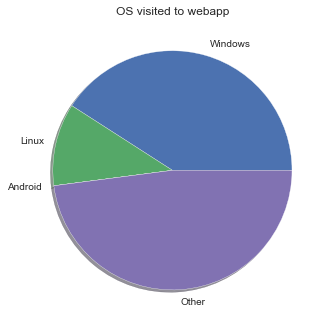

In [ ]:
plt.pie( list(OS.values()), labels=list(OS.keys()),shadow=True)
plt.title("OS visited to webapp")
plt.show()

# Hit vs Time plot

In [45]:
import plotly.express as px
fig = px.line( x = df['time'].unique(), y=df['time'].value_counts(sort = False))
fig.show()

# Plotting graph according to user geo location

In [ ]:
locate=pd.Series(co)

In [ ]:
freq_locate=locate.value_counts()
locate_index=list(freq_locate.index)
freq_locate=list(freq_locate)

In [ ]:
geodata=[]
for i in range(len(locate_index)):
    temp=[locate_index[i]]*freq_locate[i]
    geodata.append(temp)
flat_list = [item for sublist in geodata for item in sublist]

In [ ]:
gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

In [ ]:
locate_index

['Unknown',
 'India',
 'United States',
 'Australia',
 'Canada',
 'Spain',
 'Philippines',
 'Slovenia',
 'China',
 'Netherlands',
 'Malaysia',
 'Germany',
 'Brazil',
 'Austria',
 'United Kingdom']

In [ ]:
loc_codes=['IND','USA','CAN','ESP','AUS','SVN','DEU','CHN','NLD','PHL','GBR','MYS','AUT','BRA']
locate_index.remove('Unknown')
newlist=[i for i in flat_list if i!='Not found']
codes=[]
for i in newlist:
    for j in range(len(locate_index)):
        if i==locate_index[j]:
            codes.append(loc_codes[j])

In [ ]:
world_map= folium.Map(control_scale=True)
marker_cluster = MarkerCluster().add_to(world_map)

In [ ]:
geolocator = Nominatim(user_agent="myappname")
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan
latitude=[]
longitude=[]
counter=0
for i in loc_codes:
    temp=geolocate(i)
    latitude.append(temp[0])
    longitude.append(temp[1])
    print(counter)
    counter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
newlati=[]
newlongi=[]
for i in codes:
    for j in range(len(loc_codes)):
        if i==loc_codes[j]:
            newlati.append(latitude[j])
            newlongi.append(longitude[j])

for i in range(len(newlati)):
        lat = newlati[i]
        long = newlongi[i]
        radius=5
        popup_text = """Country : {}<br>
                    %of Users : {}<br>"""
                )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)

In [ ]:
world_map